<a href="https://colab.research.google.com/github/kshuravi/Credit_Card_Churn_Prediction/blob/main/Churn_Probability_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This project is mainly focused on predicting a client's probability of churning their credit card account. For that the overall performance of the prediction must be high. I have included some machine learning models to find out the accuracy of their predictions. Based on the high performance prediction, the probability of churning accounts was added for each customer. Furthermore, based on the new acquired dataset, I analyzed how to prevent customers from churning their accounts.

The dataset that I'm using is from kaggle.
Here is the link. https://www.kaggle.com/sakshigoyal7/credit-card-customers 

I cleaned and preprocessed the data before carrying out the testing and training.

## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


##Importing the dataset

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kshuravi","key":"c5b8516c7c0691ddf59fc4765d40f732"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sakshigoyal7/credit-card-customers

  0% 0.00/379k [00:00<?, ?B/s]
100% 379k/379k [00:00<00:00, 57.1MB/s]


In [4]:
from zipfile import ZipFile
file_name="credit-card-customers.zip"

with ZipFile(file_name,'r') as zipfile:
  zipfile.extractall()
  print('Done')

Done


In [5]:
data_all = pd.read_csv('BankChurners.csv')
data_all.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


##  Cleaning the data, identifying and handling the missing values.

Notice that the last two columns are unnecesary. So, I'm removing them and also making sure if the dataset has any null value.

In [6]:
data = data_all.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1)
data.isnull().values.any()

False

It's true there is no null rows but there could be non null values which do not show proper values as well. So looking over to the categorical features.

In [7]:
{column: list(data[column].unique()) for column in data.select_dtypes('object').columns}

{'Attrition_Flag': ['Existing Customer', 'Attrited Customer'],
 'Card_Category': ['Blue', 'Gold', 'Silver', 'Platinum'],
 'Education_Level': ['High School',
  'Graduate',
  'Uneducated',
  'Unknown',
  'College',
  'Post-Graduate',
  'Doctorate'],
 'Gender': ['M', 'F'],
 'Income_Category': ['$60K - $80K',
  'Less than $40K',
  '$80K - $120K',
  '$40K - $60K',
  '$120K +',
  'Unknown'],
 'Marital_Status': ['Married', 'Single', 'Unknown', 'Divorced']}

Some of the categorical features contain the category named "Unknown".

So replacing the ordinal categorical Unknowns with the mode of the feature.
Keeping the features which have nominal categories as it is. They will be taken care of later.

In [8]:
print("Mode of Education_Level:\n", data['Education_Level'].mode())
print("\nMode of Income_Category:\n", data['Income_Category'].mode())

Mode of Education_Level:
 0    Graduate
dtype: object

Mode of Income_Category:
 0    Less than $40K
dtype: object


In [9]:
# Encode unknown values as np.NaN
data = data.replace('Unknown', np.NaN)
    
# Fill ordinal missing values with modes (Education_Level and Income_Category columns)
data['Education_Level'] = data['Education_Level'].fillna('Graduate')
data['Income_Category'] = data['Income_Category'].fillna('Less than $40K')

data = data.replace(np.NaN, 'Unknown')

Unknown Categories from "Education_Level" and "Income_Category" have been replaced with the mode of the feature

In [10]:
{column: list(data[column].unique()) for column in data.select_dtypes('object').columns}

{'Attrition_Flag': ['Existing Customer', 'Attrited Customer'],
 'Card_Category': ['Blue', 'Gold', 'Silver', 'Platinum'],
 'Education_Level': ['High School',
  'Graduate',
  'Uneducated',
  'College',
  'Post-Graduate',
  'Doctorate'],
 'Gender': ['M', 'F'],
 'Income_Category': ['$60K - $80K',
  'Less than $40K',
  '$80K - $120K',
  '$40K - $60K',
  '$120K +'],
 'Marital_Status': ['Married', 'Single', 'Unknown', 'Divorced']}

## Resampling the data

Text(0, 0.5, 'Frequency')

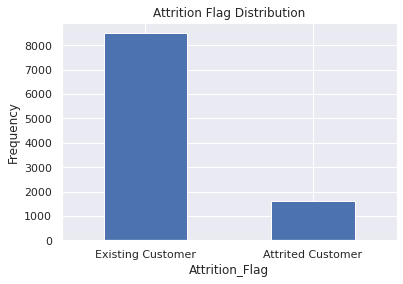

In [11]:
count_classes = pd.value_counts(data['Attrition_Flag'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Attrition Flag Distribution")
plt.xlabel("Attrition_Flag")
plt.ylabel("Frequency")

There is a huge class imbalance among the Attrition_Flag samples. Therefore, resampling is needed. I am choosing Oversampling because I do not want to lose any data.

In [12]:
# Find the number of churned and not churned accounts
churned = data[data['Attrition_Flag']=='Attrited Customer']
not_churned = data[data['Attrition_Flag']=='Existing Customer']

print(churned.shape,not_churned.shape)

(1627, 21) (8500, 21)


In [13]:
#Drop Attrition_Flag from dataset
X = data.drop(['Attrition_Flag'], axis=1)
#Get target
y = data['Attrition_Flag']

print(X.shape)
print(y.shape)

(10127, 20)
(10127,)


In [14]:
os =  RandomOverSampler(ratio=1)
X_train_res, y_train_res = os.fit_sample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [15]:
print(X_train_res.shape)
print(y_train_res.shape)

(17000, 20)
(17000,)


In [16]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({'Existing Customer': 8500, 'Attrited Customer': 1627})
Resampled dataset shape Counter({'Existing Customer': 8500, 'Attrited Customer': 8500})


In [17]:
data_res = pd.DataFrame(X_train_res, columns=X.columns)
data_res['Attrition_Flag'] = y_train_res
print(data_res.shape)

(17000, 21)


##Encoding the categorial data, splitting the dataset and perform feature scaling

In [18]:
data_res.head()

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,768805383,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691,777,11914,1.335,1144,42,1.625,0.061,Existing Customer
1,818770008,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256,864,7392,1.541,1291,33,3.714,0.105,Existing Customer
2,713982108,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418,0,3418,2.594,1887,20,2.333,0,Existing Customer
3,769911858,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313,2517,796,1.405,1171,20,2.333,0.76,Existing Customer
4,709106358,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716,0,4716,2.175,816,28,2.5,0,Existing Customer


Creating functions for different types of encoding

In [19]:
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

Encoding and Scaling the data

In [20]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Encode binary columns
    df = binary_encode(df, 'Attrition_Flag', positive_value='Attrited Customer')
    df = binary_encode(df, 'Gender', positive_value='M')
    
    # Encode ordinal columns
    education_ordering = [
        'Uneducated',
        'High School',
        'College',
        'Graduate',
        'Post-Graduate',
        'Doctorate'
    ]
    income_ordering = [
        'Less than $40K',
        '$40K - $60K',
        '$60K - $80K',
        '$80K - $120K',
        '$120K +'
    ]
    df = ordinal_encode(df, 'Education_Level', ordering=education_ordering)
    df = ordinal_encode(df, 'Income_Category', ordering=income_ordering)
    
    # Encode nominal columns
    df = onehot_encode(df, 'Marital_Status', prefix='MS')
    df = onehot_encode(df, 'Card_Category', prefix='CC')
    
    # Split df into X and y
    ys = df['Attrition_Flag'].copy()
    X_s = df.drop('Attrition_Flag', axis=1).copy()
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    Xs = pd.DataFrame(scaler.fit_transform(X_s), columns=X_s.columns)
    
    return Xs, ys

In [22]:
Xs, ys = preprocess_inputs(data_res)

Removing CLIENTNUM variable because it is unnessary

In [23]:
Xsp =Xs.drop('CLIENTNUM', axis=1)

Final data that is to be put to train and test

In [24]:
Xsp.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,MS_Divorced,MS_Married,MS_Single,MS_Unknown,CC_Blue,CC_Gold,CC_Platinum,CC_Silver
0,-0.187168,1.093793,0.479729,-0.904756,0.603237,0.374421,0.885526,-1.507768,0.295832,0.476007,-0.214802,0.497096,2.732086,-0.888901,-0.657559,3.967883,-0.612263,-0.286314,1.105936,-0.811204,-0.289906,0.268606,-0.108833,-0.052089,-0.236294
1,0.320021,-0.914250,2.024166,0.568929,-0.870399,1.006059,1.516268,-1.507768,-0.589425,-0.015126,-0.117264,-0.003542,3.667308,-0.841076,-1.056545,12.448549,-0.453513,-0.286314,-0.904212,1.232736,-0.289906,0.268606,-0.108833,-0.052089,-0.236294
2,0.573616,1.093793,0.479729,0.568929,1.340056,-0.004563,0.254783,-1.507768,-2.359938,-0.550888,-1.085914,-0.443511,8.447835,-0.647169,-1.632857,6.842135,-0.832348,-0.286314,1.105936,-0.811204,-0.289906,0.268606,-0.108833,-0.052089,-0.236294
3,-0.821154,-0.914250,1.251947,-0.904756,-0.870399,-0.257218,-0.375960,1.536179,-1.474681,-0.562515,1.735951,-0.733797,3.049880,-0.880117,-1.632857,6.842135,1.909694,-0.286314,-0.904212,-0.811204,3.449396,0.268606,-0.108833,-0.052089,-0.236294
4,-0.821154,1.093793,0.479729,-1.641599,0.603237,-1.899479,0.885526,-1.507768,-2.359938,-0.407147,-1.085914,-0.299807,6.545612,-0.995615,-1.278203,7.520101,-0.832348,-0.286314,1.105936,-0.811204,-0.289906,0.268606,-0.108833,-0.052089,-0.236294


## Train and test data with 70% - 30% ratio

In [25]:
X_train, X_test, y_train, y_test = train_test_split(Xsp, ys, test_size=0.3, random_state=50)

* Logistic Regression Model

In [26]:
#Fit the Logistic Regression Model
logmodel = LogisticRegression(random_state=50)
logmodel.fit(X_train,y_train)

#Predict the value for new, unseen data
pred = logmodel.predict(X_test)

# Find Accuracy using accuracy_score method
logmodel_accuracy = round(metrics.accuracy_score(y_test, pred) * 100, 2)

* Support Vector Machine Model

In [27]:
#Fit the Support Vector Machine Model ----------- takes longest time without preprocessing
svcmodel = SVC(kernel='linear', random_state=50, probability=True)
svcmodel.fit(X_train,y_train)

#Predict the value for new, unseen data
svc_pred = svcmodel.predict(X_test)

# Find Accuracy using accuracy_score method
svc_accuracy = round(metrics.accuracy_score(y_test, svc_pred) * 100, 2)

* K-Nearest Neighbor Model

In [28]:
#Fit the K-Nearest Neighbor Model
knnmodel = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2) #p=2 represents Euclidean distance, p=1 represents Manhattan Distance
knnmodel.fit(X_train, y_train) 
  
#Predict the value for new, unseen data
knn_pred = knnmodel.predict(X_test)

# Find Accuracy using accuracy_score method
knn_accuracy = round(metrics.accuracy_score(y_test, knn_pred) * 100, 2)

* Decision Tree Classification Model

In [29]:
#Fit the Decision Tree Classification Model
dtmodel = DecisionTreeClassifier(criterion = "gini", random_state = 50)
dtmodel.fit(X_train, y_train) 
  
#Predict the value for new, unseen data
dt_pred = dtmodel.predict(X_test)

# Find Accuracy using accuracy_score method
dt_accuracy = round(metrics.accuracy_score(y_test, dt_pred) * 100, 2)

* Random Forest Classification Model

In [30]:
#Fit the Random Forest Classification Model
rfmodel = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 50)
rfmodel.fit(X_train, y_train) 
  
#Predict the value for new, unseen data
rf_pred = rfmodel.predict(X_test)

# Find Accuracy using accuracy_score method
rf_accuracy = round(metrics.accuracy_score(y_test, rf_pred) * 100, 2)

## Showing accuracy for all of the models and generate metrics

In [31]:
# Compare Several models according to their Accuracies
Model_Comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'K-Nearest Neighbor', 'Support Vector Machine',
              'Decision Tree', 'Random Forest'],
    'Accuracy Score %': [logmodel_accuracy, knn_accuracy, svc_accuracy, dt_accuracy, rf_accuracy]})
Model_Comparison_df = Model_Comparison.sort_values(by='Accuracy Score %', ascending=False)
Model_Comparison_df = Model_Comparison_df.set_index('Accuracy Score %')
Model_Comparison_df.reset_index()

,Accuracy Score %,Model
0,98.43,Random Forest
1,97.53,Decision Tree
2,90.25,K-Nearest Neighbor
3,84.78,Logistic Regression
4,84.69,Support Vector Machine


In [32]:
# Generate confusion matrix for Random Forest as it has maximum Accuracy
conf_mat_rfmodel = confusion_matrix(y_test, rf_pred)
conf_mat_rfmodel

array([[2488,   68],
       [  12, 2532]])

In [33]:
# Generate classification report for Random Forest
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2556
           1       0.97      1.00      0.98      2544

    accuracy                           0.98      5100
   macro avg       0.98      0.98      0.98      5100
weighted avg       0.98      0.98      0.98      5100



So, from the above report we can see that Random Forest Classification Model not only has highest accuracy, but also has very good overall performance.

##Analyzing the dataset with probability of churn prediction

Adding the predicted probablity of churn values for all the customers in a new column (slide right to see)

In [34]:
df2 = data_res
df2['Probability_of_Churn'] = rfmodel.predict_proba(Xsp[X_test.columns])[:,1]
df2.head()

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,Probability_of_Churn
0,768805383,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691,777,11914,1.335,1144,42,1.625,0.061,Existing Customer,0.01
1,818770008,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256,864,7392,1.541,1291,33,3.714,0.105,Existing Customer,0.02
2,713982108,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418,0,3418,2.594,1887,20,2.333,0,Existing Customer,0.12
3,769911858,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313,2517,796,1.405,1171,20,2.333,0.76,Existing Customer,0.00
4,709106358,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716,0,4716,2.175,816,28,2.5,0,Existing Customer,0.08


One of the goals of the company should be to increase customer retention. Hence, from the prediction that was made earlier, we can filter the data that contains more than 50% probablity to churn the account for Existing Customers. And then apply the methods for increasing customer retention based on the marketing strategy.

In [35]:
df3 = df2[df2.Attrition_Flag != 'Attrited Customer']
df4 = df3[df3.Probability_of_Churn >= 0.50]
df4.head()

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,Probability_of_Churn
56,716632758,49,F,3,Graduate,Single,Less than $40K,Blue,36,2,2,0,2802,2363,439,0.75,1295,40,0.6,0.843,Existing Customer,0.54
87,711743883,43,F,3,Uneducated,Single,Less than $40K,Blue,35,5,2,3,4026,0,4026,0.483,1237,32,0.6,0,Existing Customer,0.53
124,771075258,55,M,2,College,Single,$120K +,Silver,42,2,3,2,34516,1527,32989,0.526,1268,42,0.355,0.044,Existing Customer,0.80
152,712215258,50,F,1,Graduate,Single,$40K - $60K,Silver,31,2,2,3,18386,0,18386,0.868,1298,22,0.571,0,Existing Customer,0.84
155,713786508,42,F,5,Graduate,Married,$40K - $60K,Blue,36,3,3,3,2038,0,2038,0.786,1238,28,0.75,0,Existing Customer,0.59


One of the most common customer retention examples is rewarding consumers for doing business with a brand. Rewards programs encourage customers to return by giving them discounts, exclusive access, or special offers.

Customers who have high **average utilization ratio** and **40K+ earnings** are willing to be interested in these offers.

In [36]:
df5 = df4[df4.Avg_Utilization_Ratio > 0]
df5 = df5[df5.Income_Category != 'Less than $40K']
df6 = df5[["CLIENTNUM", "Avg_Utilization_Ratio", "Income_Category", "Attrition_Flag", "Probability_of_Churn"]]
df6

,CLIENTNUM,Avg_Utilization_Ratio,Income_Category,Attrition_Flag,Probability_of_Churn
124,771075258,0.044,$120K +,Existing Customer,0.80
245,793636308,0.355,$80K - $120K,Existing Customer,0.61
290,715120608,0.117,$60K - $80K,Existing Customer,0.62
299,754897008,0.15,$40K - $60K,Existing Customer,0.86
833,712763808,0.304,$60K - $80K,Existing Customer,0.51
1115,757266933,0.079,$60K - $80K,Existing Customer,0.51
1255,798158808,0.224,$40K - $60K,Existing Customer,0.51
1551,716253858,0.117,$80K - $120K,Existing Customer,0.60
2164,711173883,0.466,$120K +,Existing Customer,0.53
2714,714178458,0.078,$80K - $120K,Existing Customer,0.52


So these customers could be contacted and be offered rewardings to increase customer retention.

##Conclusion

Among 5 of the models that I used for prediction, Random Forest Classification Model's performance was the highest. Based on the prediction for the probability to churn, I was able to find out the existing customers who are more likely to churn their accounts.

Existing customers could be contacted and be offered rewardings based on the marketing strategy of the company. As a common example, I chose the customers who has high average utilization ratio and earn more than 40K to be contacted and offered rewardings.

There is a slight limitation of the dataset. If there were features which gave the details of complain info, occupation of the customer or reasons to churn, then the company could use them in improving customer retention process.